In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt
import math
from datetime import datetime, timedelta
from sklearn import preprocessing
#tf.logging.set_verbosity(tf.logging.INFO)


/home/simone/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:


skip_vector_dim = 5
n_y = 1 #Numero di output, Per ora sali / scendi poi metteremo neutrale


class MyModel():
    
    def __init__(self, num_lstm_units, num_lstm_layers, news_per_hour, learning_rate = 0.009,
              num_epochs = 30, minibatch_size = 128,):
        self.num_lstm_units = num_lstm_units
        self.num_lstm_layers = num_lstm_layers
        self.news_per_hour = news_per_hour
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.minibatch_size = minibatch_size
        
        

    ## Managing state through batches:
    def get_state_variables(self, state_placeholder):
        l = tf.unstack(state_placeholder, axis=0)
        rnn_tuple_state = tuple(
        [tf.nn.rnn_cell.LSTMStateTuple(l[idx][0], l[idx][1])
         for idx in range(self.num_lstm_layers)]
        )
        return rnn_tuple_state

    def get_initial_state(self):
        if(self.num_lstm_layers == 1):
            return np.zeros([self.num_lstm_layers, 2, 1, self.num_lstm_units])

        return tuple([tf.nn.rnn_cell.LSTMStateTuple(np.zeros([1, 1, self.num_lstm_units]), np.zeros([1, 1, self.num_lstm_units]))for idx in range(self.num_lstm_layers)])



    def create_placeholders(self):
        X = tf.placeholder(tf.float32, shape=(None, self.news_per_hour, skip_vector_dim), name='X')
        Y = tf.placeholder(tf.float32, shape=(None, n_y), name='Y')
        lstm_state_placeholder = tf.placeholder(tf.float32, [self.num_lstm_layers, 2, None, self.num_lstm_units],  name='lstm_state')
        
        return X, Y, lstm_state_placeholder



    def forward_propagation(self, X, init_state = None):

        if init_state != None:
            init_state = self.get_state_variables(init_state)

        # ATTENTION
        e = tf.layers.dense(inputs=X, units=1, activation=tf.nn.relu)
        alpha = tf.nn.softmax(e, name='attention_weights')   												# tf.nn.softmax(logits,axis=None, ..)
        timeSlotEmbeddings =  tf.matmul(alpha, X, transpose_a=True, name='timeSlotEmbeddings')				# tf.matmul(a,b, transpose_a=False, transpose_b=False, name=None )

        # # LSTM
        # # (see https://jasdeep06.github.io/posts/Understanding-LSTM-in-Tensorflow-MNIST/)

        timeSlotSequence = timeSlotEmbeddings															# 1 sequenza di ? sample timeSlotEmbeddings.shape = (?, 1, 2400) -> memoria tra i vari sample


        # VEDERE COME FUNZIONA BACKPROP THROUGH TIME PER VEDERE QUALE E MEGLIO
        #timeSlotSequence = tf.transpose(timeSlotEmbeddings, perm=[1, 0, 2])								# ? sequenze di 1 sample -> NON c'e memoria esplicita tra i vari sample

        #lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_lstm_units)											# Definisco il layer
        lstm_layer = tf.contrib.rnn.LSTMCell(self.num_lstm_units, use_peepholes=True)						# Definisco il layer

        lstm_network = tf.contrib.rnn.MultiRNNCell([lstm_layer] * self.num_lstm_layers)


        outputs, new_states = tf.nn.dynamic_rnn(lstm_network, timeSlotSequence,
             initial_state=init_state,  dtype="float32",time_major=True)									# Definisco la rete ricorrente tramite il layer precedente


        outputs = tf.squeeze(outputs, axis=1)
    #		outputs = tf.squeeze(outputs, axis=0)

        prediction = tf.layers.dense(outputs, 1, activation=tf.nn.sigmoid)


        return prediction, new_states



    def compute_cost(self, Y_hat, Y):
        cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Y_hat, labels = Y))		# Y * -log(sigmoid(Y_hat)) + (1 - Y) * -log(1 - sigmoid(Y_hat))
        #cost = tf.reduce_mean(tf.squared_difference(Y_hat, Y))
        return cost



    def random_mini_batches(self, X_train, Y_train):
        minibatches = list()

        m = int(len(X_train))
        if(self.minibatch_size > m):
            minibatches.append((X_train, Y_train))
            return minibatches

        minibatches.append((X_train[0:self.minibatch_size], Y_train[0:self.minibatch_size]))
        iterSize = self.minibatch_size
        while(iterSize < m):
            if(iterSize+self.minibatch_size < m):
                minibatches.append((X_train[iterSize:iterSize+self.minibatch_size], Y_train[iterSize:iterSize+self.minibatch_size]))
                iterSize += self.minibatch_size
            else:
                minibatches.append((X_train[iterSize:m],Y_train[iterSize:m]))
                iterSize = m
        return minibatches


    def run(self, X_train, Y_train, X_test, Y_test, set_verbosity=True):

        
        if(set_verbosity):
            print ("Learning rate: " +str(self.learning_rate))

        ops.reset_default_graph()                      										# to be able to rerun the model without overwriting tf variables
        m =int(len(X_train))
        costs_train = []
        costs_test = []
        cost_minibatches=[]
        accuracy_train = []
        accuracy_test = []

        # Create Placeholders of the correct shape
        X, Y, lstm_state_placeholder = self.create_placeholders()

        # Forward propagation: Build the forward propagation in the tensorflow graph
        prediction, lstm_next_state = self.forward_propagation(X, lstm_state_placeholder)	


        # Cost function: Add cost function to tensorflow graph
        cost = self.compute_cost(prediction, Y)

        # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate).minimize(cost)
        #grads = tf.train.AdamOptimizer(learning_rate = learning_rate).compute_gradients(cost)

        # Initialize all the variables globally
        init = tf.global_variables_initializer()

        #This is for computing the test accuracy every epoch
        predict_op = tf.to_float(prediction > 0.5)
        correct_prediction = tf.equal(predict_op, Y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


        # Start the session to compute the tensorflow graph
        with tf.Session() as sess:

            # Run the initialization
            if(set_verbosity):
                print('initialization')
            sess.run(init)


          # Do the training loop
            for epoch in range(self.num_epochs):
                # 1 perche per ora ho 1 sola sequenza
                lstm_state = self.get_initial_state()
                #lstm_state = np.zeros([num_lstm_layers, 2, 1, num_lstm_units])														#Ogni epoch reinizializzo stato

                minibatch_cost = 0.0
                num_minibatches = int(m / self.minibatch_size)
                if(num_minibatches == 0):
                    num_minibatches = 1
                minibatches = self.random_mini_batches(X_train, Y_train)


                for minibatch in minibatches:
                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    minibatch_X = np.asarray(minibatch_X)
                    minibatch_Y = np.asarray(minibatch_Y).reshape((len(minibatch_Y), 1))



                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _ , temp_cost, lstm_state = sess.run([optimizer, cost, lstm_next_state], feed_dict={X: minibatch_X, Y: minibatch_Y, lstm_state_placeholder: lstm_state})


                    # weights = tf.get_default_graph().get_tensor_by_name('dense_1/kernel:0')
                    #print('state: ' +str(new_state))

                    minibatch_cost += temp_cost / num_minibatches

                # Print the cost every epoch
                if  epoch % 1 == 0:

                    lstm_temp_state = self.get_initial_state()
                    trainCost, lstm_temp_state = sess.run([cost, lstm_next_state], feed_dict={X: np.asarray(X_train), Y: np.asarray(Y_train).reshape((len(Y_train), 1)), lstm_state_placeholder: lstm_temp_state})
                    costs_train.append(trainCost)
                    testCost = sess.run(cost, feed_dict={X: np.asarray(X_test), Y: np.asarray(Y_test).reshape((len(Y_test), 1)), lstm_state_placeholder: lstm_temp_state})
                    costs_test.append(testCost)

                    lstm_temp_state  = self.get_initial_state()
                    trainAccuracy, lstm_temp_state = sess.run([accuracy, lstm_next_state], feed_dict={X: np.asarray(X_train), Y: np.asarray(Y_train).reshape((len(Y_train), 1)),lstm_state_placeholder: lstm_temp_state})
                    testAccuracy = sess.run(accuracy, feed_dict={X: np.asarray(X_test), Y: np.asarray(Y_test).reshape((len(Y_test), 1)),lstm_state_placeholder: lstm_temp_state})
                    accuracy_train.append(float(trainAccuracy))
                    accuracy_test.append(float(testAccuracy))
                if  set_verbosity and epoch % 5 == 0:
                    print('miniCost ='+str(minibatch_cost))

                    print("Epoch "+str(epoch)+": \tTrain cost: "+str(trainCost)+" \tTest cost: "+str(testCost)+" \tTrain Accuracy: "+str(trainAccuracy)+" \tTest accuracy: "+str(testAccuracy))




            lstm_temp_state  = self.get_initial_state()
            trainAccuracy, lstm_temp_state = sess.run([accuracy, lstm_next_state], feed_dict={X: np.asarray(X_train), Y: np.asarray(Y_train).reshape((len(Y_train), 1)),lstm_state_placeholder: lstm_temp_state})
            testAccuracy = sess.run(accuracy, feed_dict={X: np.asarray(X_test), Y: np.asarray(Y_test).reshape((len(Y_test), 1)),lstm_state_placeholder: lstm_temp_state})

            if(set_verbosity):
                plt.figure(figsize=(20,10))
                # plt.plot(np.arange(0, len(accuracy_train)*5, 5), accuracy_train,'b', label='accuracy_train')
                # plt.plot(np.arange(0, len(accuracy_train)*5, 5), accuracy_test,'r', label='accuracy_test')
                plt.plot(range(0,len(accuracy_train)), accuracy_train,'b', label='accuracy_train')
                plt.plot(range(0,len(accuracy_train)), accuracy_test,'r', label='accuracy_test')
                plt.plot(range(0,len(costs_train)),costs_train,'--b', label='cost_train')
                plt.plot(range(0,len(costs_test)),costs_test,'--r', label='cost_test' )

                plt.ylabel('accuracy')
                plt.xlabel('epochs')
                plt.title("Learning rate =" + str(self.learning_rate))
                plt.legend()
                plt.show()

                print("Train Accuracy:", max(accuracy_train))
                print("Test Accuracy:", max(accuracy_test))

            return (max(accuracy_train), max(accuracy_test))


In [3]:
class ModelSelection():

    def modelSelection(iterations = 400, learning_rate = 0.001, minibatch_size = 512 ):
        import os
        # fold = list(train_i , dev_i)
        # train_i = (train_x, train_y) 
        tf.logging.set_verbosity(tf.logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

        best_NumLSTMUnits = 0
        best_news_per_hour = 0
        best_X_window_average = 0
        best_newsTimeToMarket = 0
        
        
        bestAccuracy = 0
        # Each day: 7 hours of trading
        for i in range(0,iterations):
            news_per_hour = np.asscalar(np.random.random_integers(10, 40))
            X_window_average = np.asscalar(np.random.random_integers(10, 40))
            newsTimeToMarket = np.asscalar(np.random.random_integers(0, 50))
            # newsTimeToMarket = 0
            numLSTMUnits = np.asscalar(np.random.random_integers(100, 1000))

            print('NewsHour: '+str(news_per_hour)+' \tXavg: '+str(X_window_average)+' \t newsTTM: '+str(newsTimeToMarket)+
                  '\t LSTMUnits: '+str(numLSTMUnits)+'\t lr: '+str(learning_rate)+'\t miniBatch: '+str(minibatch_size))
            
            
            Data.load_data(news_per_hour = news_per_hour, X_window_average=X_window_average,
                           momentum_window=30, newsTimeToMarket = newsTimeToMarket, set_verbosity=False)

            folds = Data.get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 5,  dev_num_points=100)

            k_fold_train_accuracy = []
            k_fold_dev_accuracy = []
            always_yes = []

            for fold in folds:
                print("==", end="", flush=True)
                (X_train, Y_train), (X_dev, Y_dev) = fold
                model = MyModel(num_lstm_units=numLSTMUnits, num_lstm_layers=1, news_per_hour = news_per_hour,
                                learning_rate = learning_rate, num_epochs = 30, minibatch_size = minibatch_size)
                
                (train_accuracy, dev_accuracy) = model.run(X_train=X_train, Y_train=Y_train, X_test=X_dev,
                                                             Y_test=Y_dev, set_verbosity=False)

                k_fold_train_accuracy.append(train_accuracy)
                k_fold_dev_accuracy.append(dev_accuracy)
                always_yes.append(np.sum(np.asarray(Y_dev)==1)/len(Y_dev))
            print('( train_fold_accuracy: '+str(sum(k_fold_train_accuracy) / len(folds))+ ', dev_fold_accuracy: '+str(sum(k_fold_dev_accuracy) / len(folds))+' )')
            print('Dev accuracies: '+str(k_fold_dev_accuracy))
            print('Dev predict y=1: '+str(always_yes))
            print('( train_fold_variance: '+str(np.var(np.asarray(k_fold_train_accuracy)))+ ', dev_fold_variance: '+str(np.var(np.asarray(k_fold_dev_accuracy)))+' )')

            if(dev_accuracy > bestAccuracy):
                best_NumLSTMUnits = numLSTMUnits
                best_news_per_hour = news_per_hour
                best_X_window_average = X_window_average
                best_newsTimeToMarket = newsTimeToMarket

        print('#################################\n')
        print('BEST:')
        print('best_NumLSTMUnits: '+str(best_NumLSTMUnits))
        print('best_news_per_hour: '+str(best_news_per_hour))
        print('best_X_window_average: '+str(best_X_window_average))
        print('best_newsTimeToMarket: '+str(best_newsTimeToMarket))
        print('\n#################################\n')
                    
        print('Training optimal model...')
        Data.load_data(news_per_hour = best_news_per_hour, X_window_average=best_X_window_average,
                       momentum_window=30, newsTimeToMarket = best_newsTimeToMarket)
        (X_train, Y_train), (X_test, Y_test) = Data.get_train_test_set()
        
        model = MyModel(num_lstm_units=best_NumLSTMUnits, num_lstm_layers=1, news_per_hour = best_news_per_hour,
                                learning_rate = learning_rate, num_epochs = 30, minibatch_size = minibatch_size)
        
        model.run(X_train, Y_train, X_test, Y_test)
        

    def modelSelectionFixedTTM(iterations = 100, learning_rate = 0.001, minibatch_size = 512):
        import os
        # fold = list(train_i , dev_i)
        # train_i = (train_x, train_y) 
        tf.logging.set_verbosity(tf.logging.ERROR)
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

        best_NumLSTMUnits = []
        best_news_per_hour = []
        best_X_window_average = []
        best_epoch = []
        
        Ttm_range = [0, 7, 14, 21, 35, 70, 105,210]
        Ttm_range = [14]

        
        bestAccuracy = 0
        # Each day: 7 hours of trading
        for newsTimeToMarketIndex in range(0, len(Ttm_range)):
            newsTimeToMarket = Ttm_range[newsTimeToMarketIndex]
            
            best_NumLSTMUnits.append(0)
            best_news_per_hour.append(0)
            best_X_window_average.append(0)
            
            print('\n\n\n *****************  Predicting the future at '+str(newsTimeToMarket/7)+' days ****************')
            for i in range(0,iterations):
                news_per_hour = np.asscalar(np.random.random_integers(10, 40))
                X_window_average = np.asscalar(np.random.random_integers(10, 100))
                numLSTMUnits = np.asscalar(np.random.random_integers(50, 1000))


                Data.load_data(news_per_hour = news_per_hour, X_window_average=X_window_average,
                               momentum_window=30, newsTimeToMarket = newsTimeToMarket, set_verbosity=False)

                folds = Data.get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 5,  dev_num_points=100)

                print('NewsHour: '+str(news_per_hour)+' \tXavg: '+str(X_window_average)+' \t newsTTM: '+str(newsTimeToMarket)+
                  '\t LSTMUnits: '+str(numLSTMUnits)+'\t lr: '+str(learning_rate)+'\t miniBatch: '+str(minibatch_size))
            
                k_fold_train_accuracy = []
                k_fold_dev_accuracy = []
                always_yes = []

                for fold in folds:
                    print("==", end="", flush=True)
                    (X_train, Y_train), (X_dev, Y_dev) = fold
                    model = MyModel(num_lstm_units=numLSTMUnits, num_lstm_layers=1, news_per_hour = news_per_hour,
                                learning_rate = learning_rate, num_epochs = 30, minibatch_size = minibatch_size)
                
                    (train_accuracy, dev_accuracy) = model.run(X_train,Y_train,X_dev,Y_dev, set_verbosity=False)
                    
                    
                    k_fold_train_accuracy.append(train_accuracy)
                    k_fold_dev_accuracy.append(dev_accuracy)
                    always_yes.append(np.sum(np.asarray(Y_dev)==1)/len(Y_dev))
                print('( train_fold_accuracy: '+str(sum(k_fold_train_accuracy) / len(folds))+ ', dev_fold_accuracy: '+str(sum(k_fold_dev_accuracy) / len(folds))+' )')
                print('( train_fold_variance: '+str(np.var(np.asarray(k_fold_train_accuracy)))+ ', dev_fold_variance: '+str(np.var(np.asarray(k_fold_dev_accuracy)))+' )')

            if(dev_accuracy > bestAccuracy):
                best_NumLSTMUnits[newsTimeToMarketIndex] = numLSTMUnits
                best_news_per_hour[newsTimeToMarketIndex] = news_per_hour
                best_X_window_average[newsTimeToMarketIndex] = X_window_average

        print('#################################\n')
        print('BEST:')
        print('Predicting the future at: '+str(np.asarray(Ttm_range)/7)+' days')
        print('best_NumLSTMUnits: '+str(best_NumLSTMUnits))
        print('best_news_per_hour: '+str(best_news_per_hour))
        print('best_X_window_average: '+str(best_X_window_average))
        print('\n#################################\n')
                    
        print('Training optimal model...')
        train_accs = []
        test_accs = []
        for newsTimeToMarketIndex in range(0, len(Ttm_range)):
            newsTimeToMarket = Ttm_range[newsTimeToMarketIndex]
            Data.load_data(news_per_hour = best_news_per_hour[newsTimeToMarketIndex],
                           X_window_average=best_X_window_average[newsTimeToMarketIndex],
                           momentum_window=30, newsTimeToMarket = newsTimeToMarket)
            (X_train, Y_train), (X_test, Y_test) = Data.get_train_test_set()
            
            model = MyModel(num_lstm_units=best_NumLSTMUnits[newsTimeToMarketIndex], num_lstm_layers=1,
                            news_per_hour = best_news_per_hour[newsTimeToMarketIndex],learning_rate = learning_rate,
                            num_epochs = 30, minibatch_size = minibatch_size)
                
            (train_accuracy, test_accuracy) = model.run(X_train,Y_train,X_test, Y_test)
            
            train_accs.append(train_accuracy)
            test_accs.append(test_accuracy)
        
        plt.plot(Ttm_range,train_accs,'b', label='accuracy_train')
        plt.plot(Ttm_range,test_accs,'r', label='accuracy_test' )

        plt.ylabel('accuracy')
        plt.xlabel('hours in the future')
        #plt.title("Accuracy moving the window")
        plt.legend()
        plt.show()

In [4]:
X_path = '/home/simone/Desktop/wordCountEmbedding.json'
# Y_path = '../../DataSetIndexes/indexesAAPL.csv' OLD
Y_path = '/home/simone/Desktop/NLFF/indexes/indexesAAPL.csv'

def sign(x):
    if x >= 0:
        return 1
    elif x < 0:
        #return -1
        return 0
    
class Data():
    X = []
    Y = []


    def get_train_test_set(test_percentage=0.3):
        idx_split = math.floor(len(Data.X)*(1-test_percentage))

        train_x = Data.X[:idx_split]
        train_y = Data.Y[:idx_split]
        test_x = Data.X[idx_split:]
        test_y = Data.Y[idx_split:]

        return (train_x, train_y), (test_x, test_y)



    def get_cross_validation_train_dev_set(test_percentage=0.3, k_fold = 10,  dev_num_points=100):

        # https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection/14109#14109


        # fold = list(train_i , dev_i)
        # train_i = (train_x, train_y) 
        (train_x, train_y), _  = Data.get_train_test_set(test_percentage=test_percentage)
        m = int(len(train_x))
        samples_per_fold = int( (m - dev_num_points) / k_fold)
        # print('Fold lenght: '+str(samples_per_fold))
        fold = list()
        index = 0
        while(len(fold) < k_fold):
            fold.append(((train_x[index:index+samples_per_fold], train_y[index:index+samples_per_fold]),
                    (train_x[index+samples_per_fold:index+samples_per_fold+dev_num_points], train_y[index+samples_per_fold:index+samples_per_fold+dev_num_points])))
            index += samples_per_fold

        return fold





    def load_data( momentum_window=30, X_window_average=None, news_per_hour = 10, newsTimeToMarket = 0, set_verbosity=True):
        
        if(set_verbosity):
            print('Reading dataset...')
            
        x = pd.read_json(X_path)
        x = x.rename(index=str, columns={"initTime": "PUBLICATION_DATE"})
        #cambio l'ordine dalla piu vecchia alla piu recente
        if(set_verbosity):
            print('Ordering dataset...')
        x = x.sort_values(by=['PUBLICATION_DATE'])
        x = x.reset_index(drop=True)
        
        if(X_window_average != None):
            if(set_verbosity):
                print('Moving average..')
            x['CONSTRAINING'] = x['CONSTRAINING'].rolling(window=X_window_average,center=False).mean()
            x['LITIGIOUS'] = x['LITIGIOUS'].rolling(window=X_window_average,center=False).mean()
            x['NEGATIVE'] = x['NEGATIVE'].rolling(window=X_window_average,center=False).mean()
            x['POSITIVE'] = x['POSITIVE'].rolling(window=X_window_average,center=False).mean()
            x['UNCERTAINTY'] = x['UNCERTAINTY'].rolling(window=X_window_average,center=False).mean()
            x.drop(np.arange(X_window_average-1), inplace=True)
            x = x.reset_index(drop=True)
        
        #Normalizzo
        min_max_scaler = preprocessing.MinMaxScaler()
        x[['CONSTRAINING', 'LITIGIOUS','NEGATIVE','POSITIVE','UNCERTAINTY']] = min_max_scaler.fit_transform(x[['CONSTRAINING', 'LITIGIOUS','NEGATIVE','POSITIVE','UNCERTAINTY']].values)
            

        for i, row in x.iterrows():
            x.at[i,'PUBLICATION_DATE'] =datetime.strptime(x['PUBLICATION_DATE'][i], '%Y-%m-%d %H:%M:%S +%f') + timedelta(minutes=newsTimeToMarket)

            
            
            
        y = pd.read_csv(Y_path)
        #y = y.rename(index=str, columns={"Unnamed: 0": "DATE"})
        y = y.rename(index=str, columns={"date": "DATE"})
        

        #PER ORA SCARTO GLI INDICI, POI SARA' DA METTERLI DENTRO X
        #y = y['DATE', 'close']
        for i, row in y.iterrows():
            y['DATE'].at[i] = datetime.strptime(y['DATE'][i], '%Y-%m-%d %H:%M:%S') 

        z = list()
        if(set_verbosity):
            print('y(t) - y(t-1) ...')

        #calcolo differenza price(t) - price(t-window)
        for i in range(0,momentum_window):
            z.append(523) #Valore impossibile per fare drop successivamente  
        for i in range(momentum_window,y.shape[0]):
            z.append(sign(y['close'][i] - y['close'][i-momentum_window]))
        y['close'] = z

        y = y[y['close'] != 523] #Ellimino primi valori per momentum window

        if(set_verbosity):
            plt.figure(figsize=(20,10))
            plt.plot(np.arange(0, len(x)), x['CONSTRAINING'],'b')
            plt.plot(np.arange(0, len(x)), x['LITIGIOUS'],'g')
            plt.plot(np.arange(0, len(x)), x['NEGATIVE'],'m')
            plt.plot(np.arange(0, len(x)), x['POSITIVE'],'c')
            plt.plot(np.arange(0, len(x)), x['UNCERTAINTY'],'k')
            plt.ylabel('INPUT')
            plt.xlabel('time')
            plt.show()


        X = list()
        Y = list()
        
        if(set_verbosity):
            print('Alligning dataset and constructing cube..')

        initDate = max(y['DATE'][0], x['PUBLICATION_DATE'][0])
        finalDate = min(y['DATE'][len(y)-1], x['PUBLICATION_DATE'][len(x)-1])
        i = 0
        j = 0

        # ALLINEAMENTO INIZIO
        while(y['DATE'][j] < initDate):
            j+=1
        while(x['PUBLICATION_DATE'][i] < initDate):
            i+=1

        while(x['PUBLICATION_DATE'][i] < finalDate and y['DATE'][j] < finalDate ):
            timeSlotX = list()
            while(i<len(x)-1 and y['DATE'][j] > x['PUBLICATION_DATE'][i]):
                timeSlotX.append([x['CONSTRAINING'][i],x['LITIGIOUS'][i],x['NEGATIVE'][i],x['POSITIVE'][i],x['UNCERTAINTY'][i]]) 
                i+=1


            # Da len(timeslot) dobbiamo ricondurci ad avere news_per_hour numero di news
            # Random sampling se sono troppe:
            if(len(timeSlotX) > news_per_hour):
                #timeSlotX = np.random.choice(timeSlotX, news_per_hour, replace=False)
                selectedIndexes = np.random.choice(range(0,len(timeSlotX)-1), news_per_hour, replace=False).tolist()
                timeSlotX =  [timeSlotX[index] for index in selectedIndexes]
                
            # Replicazione news se sono troppo poche
            else:
                if(len(timeSlotX) < news_per_hour):
                    index = 0
                    #Se non e presente manco una news riempi di zeri
                    if(len(timeSlotX) == 0):
                        timeSlotX.append([0] * 5)
                        
                    numNews = len(timeSlotX)

                    while(len(timeSlotX) < news_per_hour):
                        timeSlotX.append(timeSlotX[index%numNews])
    
            X.append(timeSlotX)   
            Y.append(y['close'][j])
            j+=1

        Data.X = X
        Data.Y = Y



/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead
/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: This function is deprecated. Please call randint(10, 40 + 1) instead
/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
/home/simone/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: This function is deprecated. Please call randint(100, 1000 + 1) instead


NewsHour: 39 	Xavg: 39 	 newsTTM: 41	 LSTMUnits: 516	 lr: 0.001	 miniBatch: 512
==========( train_fold_accuracy: 0.8927835106849671, dev_fold_accuracy: 0.7660000085830688 )
Dev accuracies: [0.800000011920929, 0.9800000190734863, 0.5099999904632568, 0.6899999976158142, 0.8500000238418579]
Dev predict y=1: [0.8, 0.98, 0.51, 0.59, 0.7]
( train_fold_variance: 0.0021653038181602825, dev_fold_variance: 0.0250640036449434 )
NewsHour: 25 	Xavg: 15 	 newsTTM: 13	 LSTMUnits: 645	 lr: 0.001	 miniBatch: 512
==========( train_fold_accuracy: 0.8336769700050354, dev_fold_accuracy: 0.7540000081062317 )
Dev accuracies: [0.800000011920929, 0.9800000190734863, 0.550000011920929, 0.5899999737739563, 0.8500000238418579]
Dev predict y=1: [0.8, 0.98, 0.51, 0.59, 0.7]
( train_fold_variance: 0.005538904764908068, dev_fold_variance: 0.02618400360679658 )
NewsHour: 10 	Xavg: 40 	 newsTTM: 25	 LSTMUnits: 939	 lr: 0.001	 miniBatch: 512
==========( train_fold_accuracy: 0.7725085854530335, dev_fold_accuracy: 0.73999

Ordering dataset...
Moving average..
y(t) - y(t-1) ...


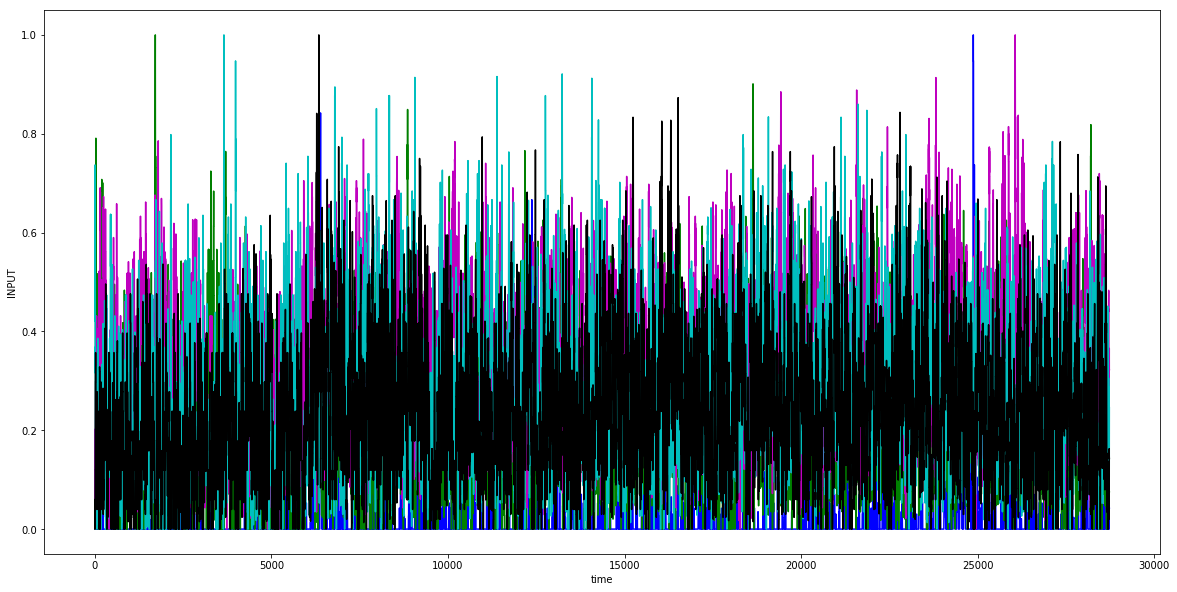

Alligning dataset and constructing cube..
Learning rate: 0.001
initialization
miniCost =0.7685894568761189
Epoch 0: 	Train cost: 0.6295823 	Test cost: 0.78031164 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.738054633140564
Epoch 5: 	Train cost: 0.6295131 	Test cost: 0.7803273 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.7380464474360148
Epoch 10: 	Train cost: 0.62950736 	Test cost: 0.78032744 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.7380442420641581
Epoch 15: 	Train cost: 0.6295055 	Test cost: 0.78032744 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.7380427718162537
Epoch 20: 	Train cost: 0.6295041 	Test cost: 0.78032744 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.7380412916342417
Epoch 25: 	Train cost: 0.62950265 	Test cost: 0.78032744 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341


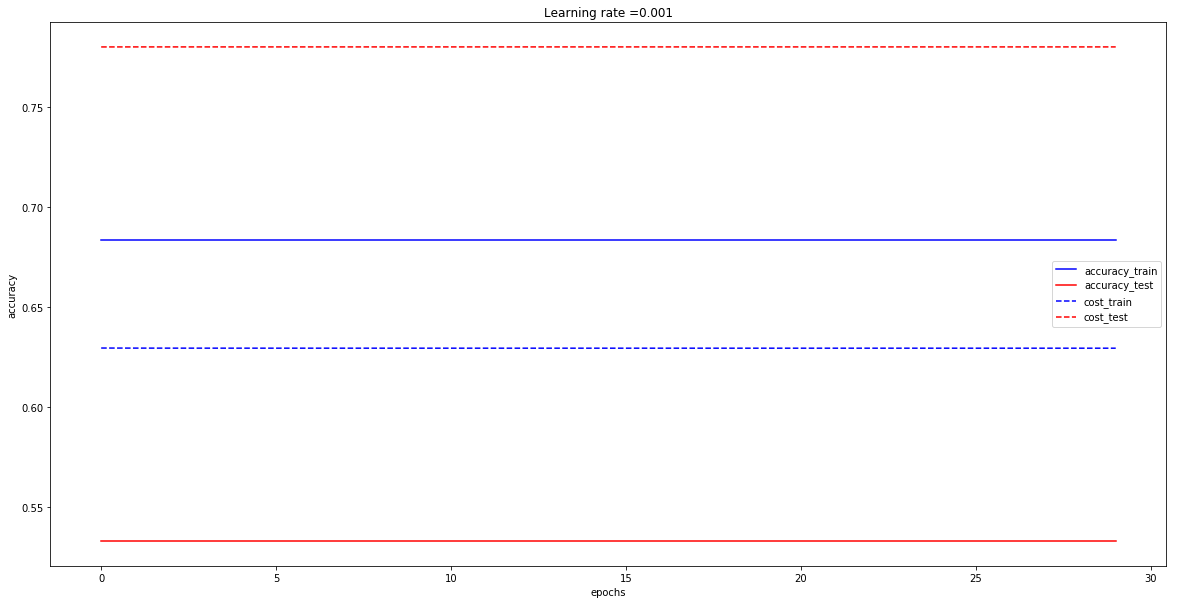

Train Accuracy: 0.6838046312332153
Test Accuracy: 0.5329341292381287


In [7]:
 ModelSelection.modelSelection(iterations =20)


# #################################

# BEST: (learning rate = 0.001, batch = 128 CREDO)
# best_NumLSTMUnits: 652
# best_news_per_hour: 33
# best_X_window_average: 30
# best_newsTimeToMarket: 0

# Train Accuracy: 0.8452174067497253
# Test Accuracy: 0.7707910537719727

# #################################


#ModelSelection.modelSelectionFixedTTM(iterations = 50, learning_rate = 0.001, minibatch_size = 512)

# #################################

# BEST:
# Predicting the future at: [ 0.  1.  2.  3.  5. 10. 15.] days
# best_NumLSTMUnits: [360, 292, 720, 237, 724, 204, 817]
# best_news_per_hour: [10, 11, 10, 39, 18, 30, 25]
# best_X_window_average: [67, 90, 47, 34, 11, 52, 76]

# #################################



Reading dataset...
Ordering dataset...
Moving average..
y(t) - y(t-1) ...


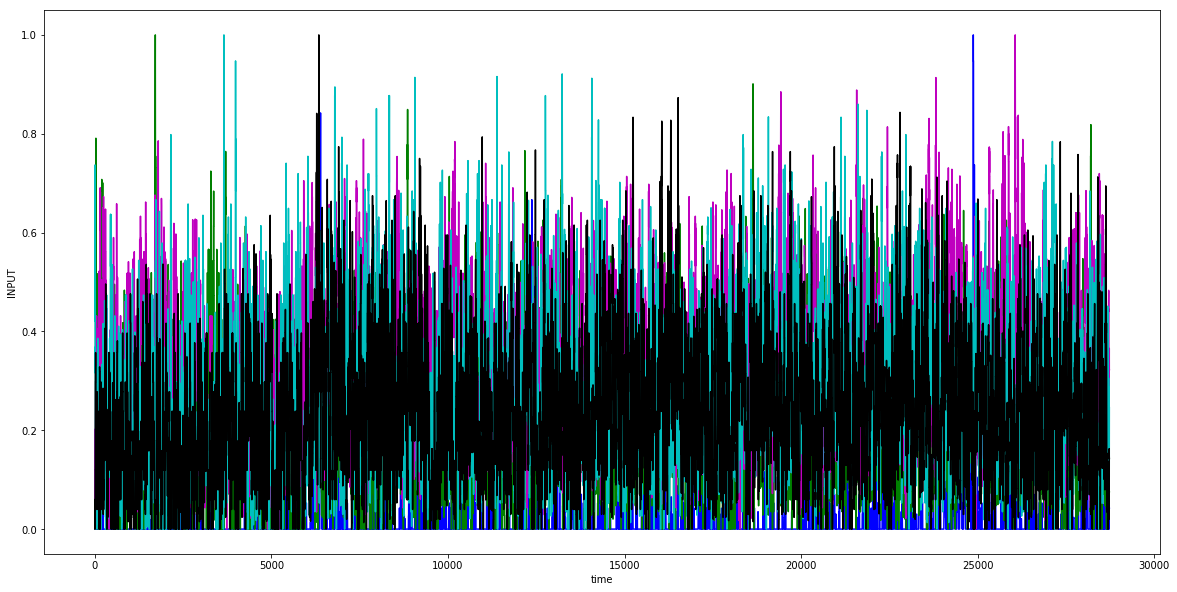

Alligning dataset and constructing cube..
.........................
number of training examples = 1556
number of test examples = 668
X_train shape: (1556, 20, 5)
Y_train shape: (1556,)
X_test shape: (668, 20, 5)
Y_test shape: (668,)
Test baseline: 0.5329341317365269
.........................
Learning rate: 0.001
initialization
miniCost =0.7636191248893738
Epoch 0: 	Train cost: 0.62957585 	Test cost: 0.7803211 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.7380533019701639
Epoch 5: 	Train cost: 0.62951183 	Test cost: 0.78032744 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.73804505666097
Epoch 10: 	Train cost: 0.629506 	Test cost: 0.78032744 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.7380426327387491
Epoch 15: 	Train cost: 0.6295039 	Test cost: 0.7803273 	Train Accuracy: 0.68380463 	Test accuracy: 0.5329341
miniCost =0.7380408147970835
Epoch 20: 	Train cost: 0.6295021 	Test cost: 0.78032744 	Train Accuracy: 0.68380463 	Test a

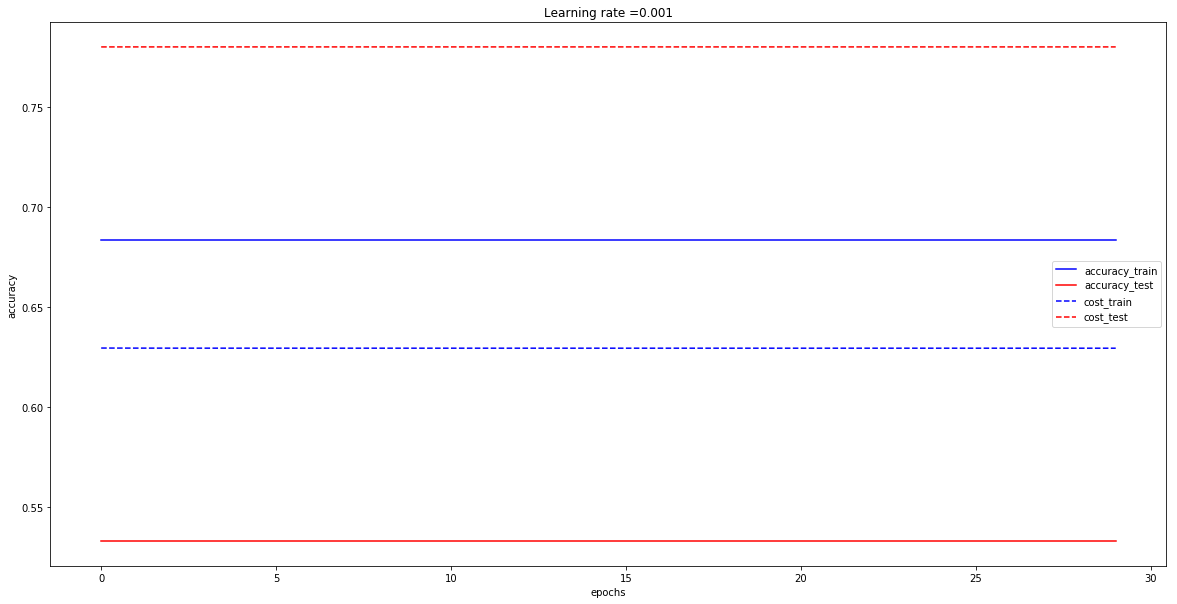

Train Accuracy: 0.6838046312332153
Test Accuracy: 0.5329341292381287


(0.6838046312332153, 0.5329341292381287)

In [8]:
### single run:
learning_rate = 0.001
batch_size = 512


num_lstm_layers = 1
num_lstm_units = 963
news_per_hour = 20
X_window_average = 15
newsTimeToMarket = 14



Data.load_data(news_per_hour = news_per_hour,
               X_window_average=X_window_average,
               momentum_window=30,
               newsTimeToMarket = newsTimeToMarket)

(X_train, Y_train), (X_test, Y_test) = Data.get_train_test_set()

test_x = tf.convert_to_tensor(np.asarray(X_test), dtype=tf.float32)
train_x = tf.convert_to_tensor(np.asarray(X_train), dtype=tf.float32)

train_y = tf.convert_to_tensor(np.asarray(Y_train), dtype=tf.float32)
test_y = tf.convert_to_tensor(np.asarray(Y_test), dtype=tf.float32)

print('.........................')
print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))
print ("Test baseline: " + str( np.sum(np.asarray(Y_test)==1)/len(Y_test)))
print('.........................')


model = MyModel(num_lstm_units=num_lstm_units, num_lstm_layers=num_lstm_layers, news_per_hour = news_per_hour,
                learning_rate = learning_rate, num_epochs = 30, minibatch_size = batch_size)

model.run(X_train, Y_train, X_test, Y_test)


In [ ]:
from __future__ import division

import numpy as np
#np.random.seed(19)
import keras
from keras.models import *
from keras import regularizers
from keras.layers import Input, Dense, Dot, merge, Flatten, Concatenate
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, merge
from keras.layers import LSTM, Lambda, Reshape, Dropout


from __future__ import division
import math



def alwaysUp(data):
    #supposed to be -1 or 1 / 0 or 1
    #supposed to predict everytime 1 (up)
    data=np.asarray(data)
    up=(data == 1).sum()/len(data)
    return up

def setBatchSize(x_train,y_train, x_test,y_test, size):
    toRemove=(len(x_train)%size)
    newxTrain=list()
    newyTrain = list()
    count=1
    #print(len(x_train))
    for i in range(0,len(x_train)):
        if(count>toRemove):
            newxTrain.append(x_train[i])
            newyTrain.append(y_train[i])
        count+=1
    #print(len(newxTrain))

    toRemove = (len(x_test) % size)
    newxTest=list()
    newyTest=list()
    count = 1
    #print(len(x_test))
    for i in range(0,len(x_test)):
        if((count < len(x_test)-toRemove+1)):
            newxTest.append(x_test[i])
            newyTest.append(y_test[i])
        count+=1

    #print(len(newxTest))
    return newxTrain,newyTrain,newxTest,newyTest


#np.random.seed(1337)  # for reproducibility
skip_vector_dim = 5
attention_input_dim = 10
# timeSpan_vector_dim = 2400 = skip_vector_dim sicuro per l'attention model



def build_model(lstmunits,regularization,batchsize,drop):
	# ATTENTION MODEL
	inputs = Input(batch_shape=(batchsize, attention_input_dim, skip_vector_dim))
	attention_alpha = Dense(1 ,activity_regularizer=regularizers.l2(regularization), activation='softmax', name='attention_vec')(inputs)
	attention = Dot(1)([attention_alpha,inputs])
	attention=Lambda(lambda y: keras.backend.permute_dimensions(y,(1,0,2)))(attention)
	attention=Dropout(drop)(attention)
	digits=LSTM(lstmunits,return_sequences=True,stateful=True)(attention)
	digits=Dropout(drop)(digits)

	#digits=Lambda(lambda y: keras.backend.permute_dimensions(y,(1,0,2)))(digits)
	digits = Lambda(lambda y: keras.backend.squeeze(y, 0))(digits)
	classification=Dense(1, activation='sigmoid',activity_regularizer=regularizers.l2(regularization))(digits)
	model = Model(input=[inputs], output=classification)

	return model

def createDataset(data,label, time_steps):
	data_x, data_y = [], []
	for i in range(len(data) - time_steps - 1):
		a = data[i:(i + time_steps)]
		data_x.append(a)
	for i in range(len(label)-time_steps-1):
		data_y.append(label[i + time_steps])
	return np.array(data_x), np.array(data_y)


def findMaxAcc(valacc,valloss):
	prevloss=valloss[0]
	for i in range(1,len(valloss)):
		if(valloss[i]>prevloss):
			return valacc[i-1]
	print('Problems with find MaxAccuracy')
	return valacc[len(valacc)-1]

def model(learning,lstmunits,regularization,drop,x_train, y_train, x_test, y_test):
	max_features = 5
	batch_size = 10
	#print('============================================================')
	x_train, y_train, x_test, y_test = setBatchSize(x_train, y_train, x_test, y_test, batch_size)
	#print('============================================================')
	x_train = np.nan_to_num(np.asarray(x_train, dtype=float))
	y_train = np.nan_to_num(np.asarray(y_train, dtype=float))
	x_test = np.nan_to_num(np.asarray(x_test, dtype=float))
	y_test = np.nan_to_num(np.asarray(y_test, dtype=float))

	y_test = (y_test + 1) / 2
	y_train = (y_train + 1) / 2

	model = build_model(drop=drop,lstmunits=lstmunits,regularization=regularization,batchsize=batch_size)
	opt=keras.optimizers.Adam(lr=learning)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	#print(model.summary())
	#print('Train...')
	uptr = alwaysUp(y_train)
	upts = alwaysUp(y_test)
	#print('Only up:', uptr)
	#print('Only up:', upts)

	history=model.fit(x_train, y_train, batch_size=batch_size, epochs=20,verbose=0, shuffle=False, validation_data=(x_test, y_test))
	maxAcc=findMaxAcc(history.history['val_acc'],history.history['val_loss'])

	#print('Here you are the max acc')
	#print(maxAcc)
	
	plt.plot(history.history['acc'])
	plt.plot(history.history['val_acc'])
	plt.title('model accuracy :')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()

	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('model loss :')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='upper left')
	plt.show()
	#score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
	#print('Test score:', score)
	#print('Test accuracy:', acc)
	return maxAcc, upts




def crossValidation(x_data, y_data, nfold,learning,mem,regu,drop,windowdim):
    dimfolf=(len(x_data)//nfold)
    # -1 so the last fold is bigger ex 100/8=12,5 last fold from 11 to 12,5
    acclist=list()
    baselist=list()
    move=(len(x_data)-windowdim)//nfold
    for i in range(0,nfold):

        xdataToPass=x_data[0+move*i:windowdim+move*i]
        ydataToPass = y_data[0+move*i:windowdim+move*i]
        acc,base=execModel(xdataToPass, ydataToPass,learning,mem,regu,drop)
        acclist.append(acc)
        baselist.append(base)

    return acclist,baselist

def splitData(x_data,y_data, valperc):
    val=math.ceil(len(x_data)*valperc)
    x_train=x_data[0:val]
    y_train=y_data[0:val]
    x_val=x_data[val:]
    y_val=y_data[val:]
    return x_train,y_train,x_val,y_val


def execModel(x_data,y_data,learning,mem,regu,drop):
    x_train,y_train,x_val,y_val=splitData(x_data,y_data,0.7)
    maxAcc,base=model(learning, mem, regu,drop, x_train, y_train, x_val, y_val)
    return maxAcc,base

In [ ]:
Data.load_data(news_per_hour = 10, X_window_average=60, momentum_window=30, newsTimeToMarket = 20)

(X_train, Y_train), (X_test, Y_test) = Data.get_train_test_set()

test_x = tf.convert_to_tensor(np.asarray(X_test), dtype=tf.float32)
train_x = tf.convert_to_tensor(np.asarray(X_train), dtype=tf.float32)

train_y = tf.convert_to_tensor(np.asarray(Y_train), dtype=tf.float32)
test_y = tf.convert_to_tensor(np.asarray(Y_test), dtype=tf.float32)

print('.........................')
print ("number of training examples = " + str(train_x.shape[0]))
print ("number of test examples = " + str(test_x.shape[0]))
print ("X_train shape: " + str(train_x.shape))
print ("Y_train shape: " + str(train_y.shape))
print ("X_test shape: " + str(test_x.shape))
print ("Y_test shape: " + str(test_y.shape))
print('.........................')



print ("Test baseline: " + str( np.sum(np.asarray(Y_test)==1)/len(Y_test)))
#print(model(0.00001,512,0.001,0,X_train, Y_train, X_test, Y_test))

nfold=10
learning=[0.0001,0.00001,0.000001,0.0000001]
mem=[756,1024]
reg=[0.001,0.05,0.5]
drop=[0,0.25]
resultsacc=list()
resultsbase=list()

for d in drop:
    for r in reg:
        for m in mem:
            for l in learning:
                acclist, baselist = crossValidation(X_train, Y_train, nfold, l, m, r,d,800)
                acc=np.asarray(acclist)
                base=np.asarray(baselist)
                acc=acc.mean()
                base=base.mean()

                print('Drop:',d)
                print('Reg:',r)
                print('Mem:',m)
                print('Learning',l)
                print('AAAAAAAccuracy:',acc)
                print('BBBBBBBBBBBase:',base)
                print('------------------------------------------------------------')


In [ ]:
Ttm_range = [0, 7, 14, 21, 35, 70, 105]

train_accs = []
test_accs = []
for newsTimeToMarketIndex in range(0, len(Ttm_range)):
    newsTimeToMarket = Ttm_range[newsTimeToMarketIndex]
    Data.load_data(news_per_hour = best_news_per_hour[newsTimeToMarketIndex], X_window_average=best_X_window_average[newsTimeToMarketIndex],
               momentum_window=30, newsTimeToMarket = newsTimeToMarket)
    (X_train, Y_train), (X_test, Y_test) = Data.get_train_test_set()
    (train_accuracy, test_accuracy) = MyModel.model(X_train, Y_train, X_test, Y_test,  minibatch_size = batch_size, learning_rate = learning_rate,num_lstm_layers=num_lstm_layers, num_lstm_units = num_lstm_units, news_per_hour = news_per_hour)
    train_accs.append(train_accuracy)
    test_accs.append(test_accuracy)

plt.plot(Ttm_range,train_accs,'b', label='accuracy_train')
plt.plot(Ttm_range,test_accs,'r', label='accuracy_test' )

In [ ]:
Ttm_range = [ 0,  1,  2,  3,  5, 10, 15, 30]
train_accs = [0.782608687877655, 0.8426086902618408, 0.7408695816993713, 0.8895652294158936, 0.7260869741439819, 0.8408695459365845,0.678260862827301,0.678260862827301]
test_accs = [0.8133874535560608, 0.8215010166168213, 0.7606490850448608, 0.8580121994018555, 0.7444218993186951, 0.7910750508308411, 0.5841785073280334, 0.5841785073280334]


plt.figure(figsize=(20,10))

plt.plot(Ttm_range,train_accs,'b', label='accuracy_train')
plt.plot(Ttm_range,test_accs,'r', label='accuracy_test' )

plt.ylabel('accuracy')
plt.xlabel('days in the future')
#plt.title("Accuracy moving the window")
plt.legend()
plt.show()

In [9]:
a =pd.read_csv('/home/simone/Desktop/NLFF/indexes/indexesHOLX.csv')

,Unnamed: 0,open,high,low,close,volume,date,close_12_ema,close_26_ema,macd,...,macdh,macd.1,macds.1,boll_ub,boll_lb,rsi_6,rsi_12,vr_6_sma,wr_10,wr_6
0,2014-12-08 23:00:00,26.520,26.610,26.45,26.5600,49036,2014-12-08 15:00:00,26.560000,26.560000,0.000000,...,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,31.250000,31.250000
1,2014-12-09 00:00:00,26.560,26.620,26.56,26.6050,94679,2014-12-08 16:00:00,26.584375,26.583365,0.001010,...,0.000897,0.001010,0.000561,26.646140,26.518860,100.000000,100.000000,NaN,8.823529,8.823529
2,2014-12-09 01:00:00,26.605,26.710,26.59,26.6801,118340,2014-12-08 17:00:00,26.621736,26.618121,0.003615,...,0.003605,0.003615,0.001813,26.736384,26.493683,100.000000,100.000000,NaN,11.500000,11.500000
3,2014-12-09 02:00:00,26.690,26.750,26.63,26.6600,177297,2014-12-08 18:00:00,26.633815,26.629829,0.003986,...,0.002874,0.003986,0.002549,26.735084,26.517466,82.358104,84.142533,120.148113,30.000000,30.000000
4,2014-12-09 03:00:00,26.670,26.725,26.63,26.6700,144210,2014-12-08 19:00:00,26.643646,26.639145,0.004502,...,0.002744,0.004502,0.003130,26.737045,26.532995,84.039174,85.399154,160.817160,26.666667,26.666667
5,2014-12-09 04:00:00,26.660,26.670,26.57,26.6250,329470,2014-12-08 20:00:00,26.639114,26.636312,0.002803,...,-0.000477,0.002803,0.003041,26.724970,26.541730,55.487592,61.481600,130.708695,41.666667,41.666667
6,2014-12-09 05:00:00,26.630,26.670,26.61,26.6300,767812,2014-12-08 21:00:00,26.637080,26.635189,0.001891,...,-0.001718,0.001891,0.002750,26.716547,26.549196,57.416572,62.746275,153.532422,40.000000,63.157895
7,2014-12-09 23:00:00,26.540,26.620,26.30,26.4600,96577,2014-12-09 15:00:00,26.600126,26.606962,-0.006835,...,-0.014564,-0.006835,0.000447,26.755981,26.466544,20.742231,28.292046,160.119455,64.444444,64.444444
8,2014-12-10 00:00:00,26.465,26.560,26.41,26.5000,106790,2014-12-09 16:00:00,26.580318,26.591108,-0.010790,...,-0.017281,-0.010790,-0.002149,26.753262,26.444538,32.852345,37.150466,167.460758,55.555556,55.555556
9,2014-12-10 01:00:00,26.500,26.640,26.46,26.6350,62224,2014-12-09 17:00:00,26.590680,26.597164,-0.006484,...,-0.006728,-0.006484,-0.003120,26.749824,26.455196,58.520510,56.799465,183.182816,25.555556,21.176471
